## <code>LPGerchbergSaxton_SLM_3spots_v2.ipynb </code> 
    - 12-10-2021 (v2 update): dX = 75um, dZ = 70um, DX = 280um to match the beam spacing in Zemax simulation

## Computer generated hologram using Gerchberg-Saxton algorithm
 
#### Adapted to Python 3.7 by Raghav K. Chhetri (May 2021) from the following MATLAB scripts 
    - Original by Dr F.A. van Goor, University of Twente (April 2010)
    - Reorganized by Adam Packer (December 2013) -> SLMPhaesMaskMaker_LightPipes.m
    - Keller-D9
    
My MATLAB script <code>D:/Dropbox (Personal)/slm.rc__Convert-to-Python/LPGerchbergSaxton_RC_SLM1920_v3_beta.m</code>

In [1]:
from LightPipes import *
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from os.path import join
import time
import sys

Version of packages used in this notebook:

In [2]:
print('Environment: {}'.format(sys.exec_prefix))
print('Executable: {}'.format(sys.executable))
print('Python version: {}'.format(sys.version))
print('Numpy', np.__version__)
print('Matplotlib', matplotlib.__version__)
print('LightPipes', LPversion)
LPtest()

Environment: D:\Anaconda3\envs\lightpipes
Executable: D:\Anaconda3\envs\lightpipes\python.exe
Python version: 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
Numpy 1.18.1
Matplotlib 3.1.3
LightPipes 2.0.5
Test OK


In [25]:
wavelength = 488*nm

#dx and dz of spots in the sample plane
dx  = 75*um; 
dz = 70*um; 

#separation between each set 
Dx  = 280*um; 

MagAM = 6; #Magnification from sample to Apodizing Mask

# Spacing at the Apodizing Mask
dX = MagAM*dx; 
dZ = MagAM*dz; 
DX = MagAM*Dx; 

fSLM = 750*mm
SLMpixel = 9.2*um
SLMheight = 1920
SLMwidth = 1152
gridsize = np.ceil((fSLM*wavelength/SLMpixel)/dZ)*dZ

#Choose Nunits 'Number of grid-units per dXdZ' such that gridpixels > SLMheight
Nunits = 30; #even; For 488, 30 and up; For 561/631, 20 and up; [20,30,60,70,140,210]
unit = dZ/Nunits
gridpixels = int(gridsize/unit)

#Optic axis co-ordinate(zero-order beam)
Oaxis = gridsize/2
#Define the position of the center beam in the 3x3 array
#X = Oaxis + dX/2
#Z = Oaxis + dZ/2
X = Oaxis
Z = Oaxis - 2*dZ

#Beam diameter on the SLM (1/e diameter); Recall that 1/e_width = 1.2 x FWHM_width
beamD = 1.2*9*mm

Field= Begin(gridsize, wavelength, gridpixels) #Plane wave distribution with amplitude 1 and phase 0
#Field= GaussAperture(Field, w = beamD/2, x_shift=0.0, y_shift=0.0, T=1.0) #An aperture with a Gaussian shape
Field= GaussBeam(Field, beamD/2)

"""
#To insert cylindrical lens pair
f1 = 150*mm
angle1 = 0.0*deg
f2 = 50*mm
angle2 = 0.0*deg
Field = CylindricalLens(Field,f1,angle=angle1) # cylindrical lens f1
Field = Forvard(Field,f1+f2) # propagate f1+f2
Field = CylindricalLens(Field,f2,angle=angle2) # cylindrical lens f2
Field = Forvard(Field,3*(f1+f2)) # propagate 3*(f1+f2)
"""
SLMfield = RectAperture(Field, sx=SLMheight*SLMpixel, sy=SLMwidth*SLMpixel, x_shift=0.0, y_shift=0.0, angle=0.0)
print(type(SLMfield.field), SLMfield.field.dtype, SLMfield.field.shape)

<class 'numpy.ndarray'> complex128 (2850, 2850)


In [26]:
print('Pixels in the grid:', gridpixels)
print('Pixels along SLM height:',SLMheight)
print('OK to proceed') if gridpixels > SLMheight else print('Increase "Nunits" such that "gridpixels" > "SLMheight"')

Pixels in the grid: 2850
Pixels along SLM height: 1920
OK to proceed


<class 'numpy.ndarray'> (2850, 2850) 0.0 255.0 float64


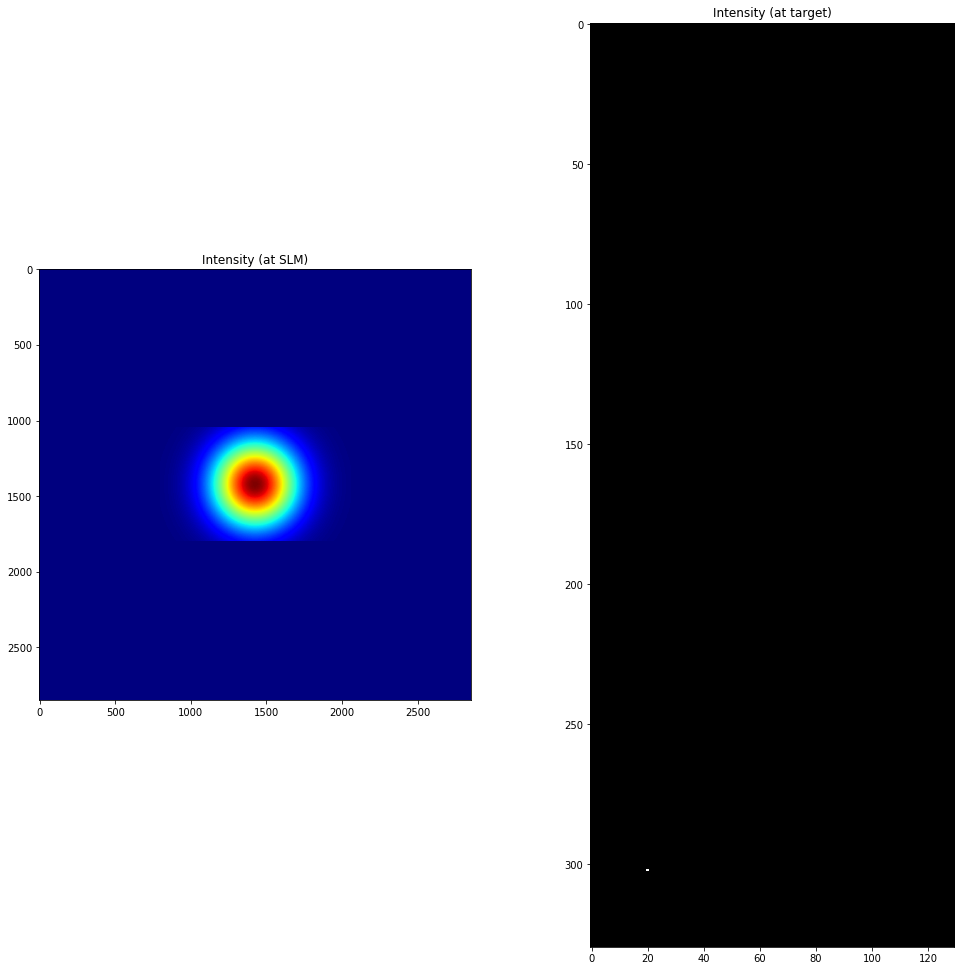

In [27]:
# Define beam-spot positions in the target grid

#tag = 'FAR' #Beams-1-4-7
#spots_X = np.array([(X-dX)-DX, (X-dX), (X-dX)+DX])/unit
#spots_Z = np.array([Z-dZ, Z-dZ, Z-dZ])/unit

#tag = 'MID' #Beams-2-5-8
#spots_X = np.array([X-DX, X, X+DX])/unit
#spots_Z = np.array([Z, Z, Z])/unit

#tag = 'NEAR' #Beams-3-6-9
#spots_X = np.array([(X+dX)-DX, (X+dX), (X+dX)+DX])/unit
#spots_Z = np.array([Z+dZ, Z+dZ, Z+dZ])/unit

tag = 'DIAGONAL' #Beams-1-5-9
spots_X = np.array([(X-dX)-DX, X, (X+dX)+DX])/unit
spots_Z = np.array([Z-dZ, Z, Z+dZ])/unit

spots_X = spots_X.astype(int)
spots_Z = spots_Z.astype(int)

# To flip the orientation of the spots
# spots_Xf = spots_Z;
# spots_Zf = spots_X;

target = np.zeros((gridpixels, gridpixels)) #Note: LightPipes command 'SubIntensity' needs floats
for j in range(len(spots_X)):
    target[spots_X[j],spots_Z[j]] = 255
print(type(target), target.shape, np.min(target), np.max(target), target.dtype)

ISLM = Intensity(SLMfield)

#Plots
high= 300
wide= 100 
offset= 30
top= len(target)//2 - high//2
bottom= len(target)//2 + high//2 + offset
left= len(target)//2 - wide//2
right= len(target)//2 + wide//2 + offset

plt.figure(figsize=(17,17))
plt.subplot(1,2,1)
plt.title('Intensity (at SLM)')
plt.imshow(ISLM,cmap='jet')
plt.subplot(1,2,2)
plt.title('Intensity (at target)')
plt.imshow(target[top:bottom,left:right], cmap='gray')
plt.show()

In [28]:
print(len(spots_X))
print(spots_X, spots_Z)
print(target[spots_X[0], spots_X[0]], target[spots_X[1], spots_Z[1]], target[spots_X[2], spots_Z[2]])

3
[1272 1425 1577] [1335 1365 1395]
0.0 255.0 255.0


In [29]:
# Iteration loop to get phase distribution
Niter = 12 
Field = SLMfield
UniformIntensity = np.ones((gridpixels, gridpixels)) #Matrix filled with 1's to substitute a uniform intensity profile

t0 = time.time()
for i in range(Niter):    
    #print(i)  
#2-D Fourier transform of the field; Forward transform with index 1
    Field = PipFFT(Field, index = 1)     
#Substitute the original intensity distribution while leaving the phase unchanged
    Field = SubIntensity(Field, target)
#Inverse Fourier transform; Back transform with index -1
    Field = PipFFT(Field, index = -1) 
#Substitute a uniform intensity while leaving the phase unchanged
    Field = SubIntensity(Field, UniformIntensity)
print('Took', round(time.time()-t0,2), 'sec')

Took 46.4 sec


<class 'numpy.ndarray'> (2850, 2850) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


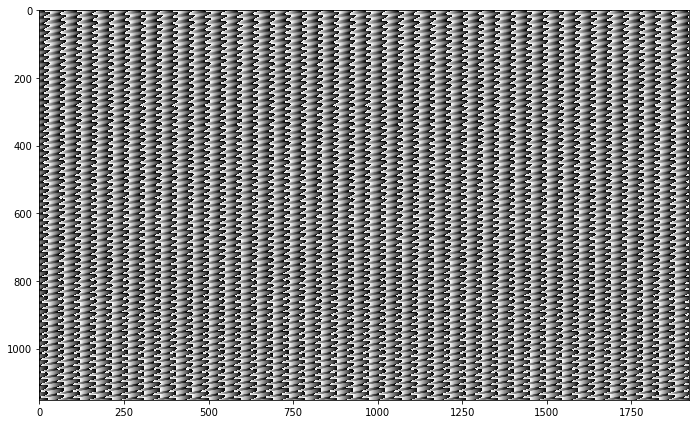

Took 0.62 sec


In [30]:
t0 = time.time()
#Extract the phase distribution from the field
Phaze = Phase(Field) 
PhaseZeroed = Phaze + np.abs(np.min(Phaze))

# Convert to 8-bit
Phase8 = PhaseZeroed*(255/np.max(PhaseZeroed))
print(type(Phase8), Phase8.shape, Phase8.dtype)
phaseMask8 = Phase8[0:SLMwidth,0:SLMheight].astype('uint8')
print(type(phaseMask8), phaseMask8.shape, phaseMask8.dtype)

fig = plt.figure(figsize=(10,6))
#plt.imshow(phaseMask8,cmap='gray')
#plt.show()
io.imshow(phaseMask8); io.show()
print('Took', round(time.time()-t0,2), 'sec')

In [31]:
outPath= 'D:/Desktop/img/'
outfilename= str(int(wavelength/nm))+ \
'nm_Points_Target.'+str(Nunits)+ \
'units.in.'+str(int(dZ/um))+ \
'um_Niter'+str(Niter) +'_' +tag +'_v5.bmp' 
#plt.imsave(join(outPath, outfilename), phaseMask8, cmap='gray') # Note that plt.imsave saves it as 32-bit instead of 8-bit
io.imsave(join(outPath, outfilename), phaseMask8)